In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [2]:
import random # random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accesso ai file
import datetime # dati temporali (date, ore)
import tensorflow as tf # Per creare reti neurali
import pandas as pd # Tabelle
import matplotlib # Grafici
import matplotlib.pyplot as plt #Grafici
import cv2 # Immagini
import keras # Semplifica la creazione di reti neurali
# from keras.optimizers import Adam # allenatore
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow import keras # idem
from sklearn.model_selection import train_test_split # Divide i dati in training set e test set
from sklearn.preprocessing import LabelEncoder # Converte le parole in numeri ("Gatto" = 0, "Cane" = 1, ...)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Per gestire il dataset di immagini
from keras.models import Sequential # Per definire una rete neurale semplice, sequenziale
from tensorflow.keras import layers # I livelli di una rete neurale
from keras.layers import Dense, Dropout, Activation, Flatten # Componenti di una rete neurale
from keras.layers import Conv2D, MaxPooling2D # Convoluzioni e pooling
import seaborn as sns # Altri grafici
from sklearn.metrics import confusion_matrix # Per capire quanto è bravo il modello
from sklearn.utils import class_weight # Per bilanciare il dataset

In [3]:
def dataset(direct):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()
    
    train_dir = os.listdir(direct)
    for i in train_dir:
        if i == "Train_Test_Valid":
            continue
        class_path = os.path.join(direct, i)
        
        # 디렉터리인지 확인
        if os.path.isdir(class_path):
            classes.append(i)
            for j in os.listdir(class_path):
                file_path = os.path.join(class_path, j)
                img = cv2.imread(file_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, (224, 224))  # Resize image
                    img = img / 255.0  # Normalize
                    images.append(img)
                    labels.append(i)
                
    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

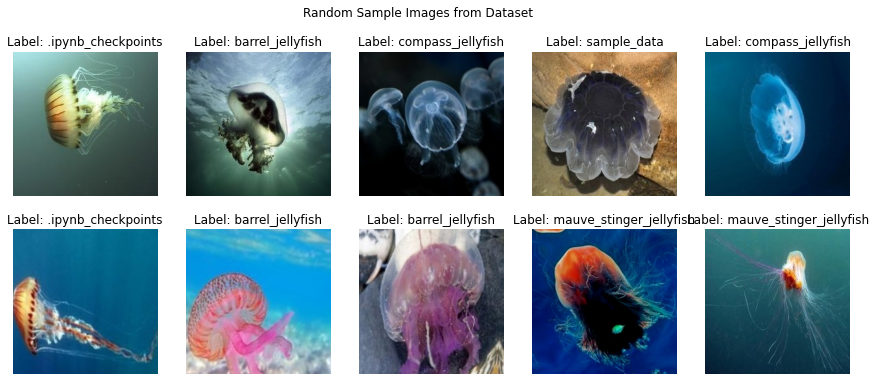

In [4]:
images, labels, classes = dataset('./jellyfish')

random_indexes = random.sample(range(len(images)), 10)

# Plot a few images at random indexes
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in zip(random_indexes, ax.flatten()):
    ax.imshow(images[idx])
    ax.set_title(f"Label: {classes[labels[idx]]}")
    ax.axis('off')
plt.suptitle('Random Sample Images from Dataset')
plt.show()

In [5]:
# training set (80%)  test set (20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# training set (75%)  "validation set" (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

classes = np.unique(classes)

In [6]:
# 데이터 증강 설정 

train_datagen = ImageDataGenerator(
    rotation_range = 10, # 이미지를 최대 10도까지 랜덤하게 회전 
    zoom_range = 0.1, # 이미지를 10%까지 랜덤하게 확대 또는 축소 
    width_shift_range = 0.2, # 이미지를 가로로 20%
    height_shift_range = 0.2, # 세롤로 20%까지 랜덤하게 이동 
    horizontal_flip = True, # 이미지를 좌우로 뒤집음
    vertical_flip = True, # 이미지를 위아래로 뒤집음 
)

test_val_datagen = ImageDataGenerator() # 검증 및 테스트 데이터 생성 설정 
# 검증과 테스트 데이터에는 증강을 적용하지 않음 
# 따라서 단순히 ImageDataGenerator()만 사용하여 원본 이미지를 그대로 사용

# 학습 데이터를 batch_size=20으로 나누어 train_datagen에 설정된 증강을 적용해 학습용 배치를 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=20)

# 검증 데이터를 batch_size=20으로 나누어 증강 없이 생성
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=20)

# 테스트 데이터를 batch_size=20으로 나누어 생성
# shuffle=False로 설정하여 데이터를 랜덤하게 섞지 않음 
# 테스트에서는 예측 결과의 순서가 일정해야 하기 때문에 보통 shuffle=False로 설정
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=20, shuffle=False)

In [7]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [8]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [12]:
def train():
    default_config = {
        "input" : (28,28,1),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model
    
    # 모델 초기화
    model = Sequential()

    # 첫 번째 convolutional layer
    model.add(Conv2D(16, 3, input_shape=(224, 224, 3), activation='relu'))

    # pooling으로 downsampling 및 convolutional layer 추가 
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(2))

    # 2D metrics를 1D vector로 flattening하여 완전 연결 층 준비 
    model.add(Flatten())
          
    # 완전 연결 층 (flatten된 특징의 비선형 조합을 학습하기 위한 relu)
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
          
    # 출력 층 (다중 클래스 분류 (6개의 클래스)에 적합)
    model.add(Dense(6, activation='softmax'))
          
    # 모델 컴파일 
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    
    history = model.fit(
    train_generator, 
    epochs=100, 
    validation_data=val_generator
    )
    
    
    test_loss, test_accuracy = model.evaluate(test_generator)
    # print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    
    
    
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [13]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_first_CNN_used_by_Jindeok")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: stslnex8
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_first_CNN_used_by_Jindeok/sweeps/stslnex8


wandb: Agent Starting Run: sj41wxmi with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.04260524050492338


Epoch 1/100
27/27 [==============================] - 38s 192ms/step - loss: 1.7641 - accuracy: 0.2074 - val_loss: 1.6387 - val_accuracy: 0.3444
Epoch 2/100
27/27 [==============================] - 5s 193ms/step - loss: 1.6113 - accuracy: 0.3037 - val_loss: 1.4249 - val_accuracy: 0.4333
Epoch 3/100
27/27 [==============================] - 5s 198ms/step - loss: 1.5349 - accuracy: 0.3463 - val_loss: 1.4070 - val_accuracy: 0.4389
Epoch 4/100
27/27 [==============================] - 5s 195ms/step - loss: 1.4799 - accuracy: 0.3741 - val_loss: 1.3985 - val_accuracy: 0.3944
Epoch 5/100
27/27 [==============================] - 5s 194ms/step - loss: 1.4542 - accuracy: 0.3907 - val_loss: 1.3644 - val_accuracy: 0.4500
Epoch 6/100
27/27 [==============================] - 5s 191ms/step - loss: 1.4195 - accuracy: 0.4185 - val_loss: 1.2926 - val_accuracy: 0.4833
Epoch 7/100
27/27 [==============================] - 5s 193ms/step - loss: 1.4176 - accuracy: 0.4093 - val_loss: 1.3451 - val_accuracy: 0.450

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,72.93
Test Error Rate:,27.07


wandb: Agent Starting Run: qf58t0ra with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.03942599265661788


Epoch 1/100
27/27 [==============================] - 6s 199ms/step - loss: 1.8474 - accuracy: 0.1981 - val_loss: 1.7786 - val_accuracy: 0.2833
Epoch 2/100
27/27 [==============================] - 5s 192ms/step - loss: 1.7582 - accuracy: 0.2630 - val_loss: 1.8492 - val_accuracy: 0.1667
Epoch 3/100
27/27 [==============================] - 5s 193ms/step - loss: 1.7350 - accuracy: 0.2537 - val_loss: 1.6805 - val_accuracy: 0.2556
Epoch 4/100
27/27 [==============================] - 5s 193ms/step - loss: 1.6744 - accuracy: 0.2796 - val_loss: 1.6391 - val_accuracy: 0.2944
Epoch 5/100
27/27 [==============================] - 5s 193ms/step - loss: 1.6132 - accuracy: 0.2833 - val_loss: 1.5281 - val_accuracy: 0.2667
Epoch 6/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5835 - accuracy: 0.3130 - val_loss: 1.5003 - val_accuracy: 0.2556
Epoch 7/100
27/27 [==============================] - 5s 194ms/step - loss: 1.5222 - accuracy: 0.3093 - val_loss: 1.5147 - val_accuracy: 0.3667

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,76.24
Test Error Rate:,23.76


wandb: Agent Starting Run: v9cbxsuj with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.0942033473593143


Epoch 1/100
27/27 [==============================] - 6s 214ms/step - loss: 1.7727 - accuracy: 0.2556 - val_loss: 1.6456 - val_accuracy: 0.3611
Epoch 2/100
27/27 [==============================] - 5s 197ms/step - loss: 1.6282 - accuracy: 0.3037 - val_loss: 1.5177 - val_accuracy: 0.3611
Epoch 3/100
27/27 [==============================] - 5s 197ms/step - loss: 1.5634 - accuracy: 0.3685 - val_loss: 1.5114 - val_accuracy: 0.3778
Epoch 4/100
27/27 [==============================] - 5s 194ms/step - loss: 1.4695 - accuracy: 0.4074 - val_loss: 1.4194 - val_accuracy: 0.4278
Epoch 5/100
27/27 [==============================] - 5s 190ms/step - loss: 1.4309 - accuracy: 0.4019 - val_loss: 1.3361 - val_accuracy: 0.5000
Epoch 6/100
27/27 [==============================] - 5s 194ms/step - loss: 1.3907 - accuracy: 0.4574 - val_loss: 1.3752 - val_accuracy: 0.4611
Epoch 7/100
27/27 [==============================] - 5s 190ms/step - loss: 1.3601 - accuracy: 0.4333 - val_loss: 1.3521 - val_accuracy: 0.4833

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,82.32
Test Error Rate:,17.68


wandb: Agent Starting Run: zetcasmq with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.043968694773931914


Epoch 1/100
27/27 [==============================] - 6s 200ms/step - loss: 1.7600 - accuracy: 0.2519 - val_loss: 1.6707 - val_accuracy: 0.3056
Epoch 2/100
27/27 [==============================] - 5s 195ms/step - loss: 1.5701 - accuracy: 0.3463 - val_loss: 1.4836 - val_accuracy: 0.3500
Epoch 3/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5040 - accuracy: 0.3574 - val_loss: 1.4261 - val_accuracy: 0.3833
Epoch 4/100
27/27 [==============================] - 5s 194ms/step - loss: 1.4057 - accuracy: 0.4241 - val_loss: 1.3192 - val_accuracy: 0.4889
Epoch 5/100
27/27 [==============================] - 5s 192ms/step - loss: 1.3882 - accuracy: 0.4185 - val_loss: 1.4313 - val_accuracy: 0.4611
Epoch 6/100
27/27 [==============================] - 5s 194ms/step - loss: 1.3656 - accuracy: 0.4426 - val_loss: 1.3256 - val_accuracy: 0.4667
Epoch 7/100
27/27 [==============================] - 5s 195ms/step - loss: 1.3238 - accuracy: 0.4852 - val_loss: 1.4181 - val_accuracy: 0.4167

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,78.45
Test Error Rate:,21.55


wandb: Agent Starting Run: 6ppw79mn with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0438954093902731


Epoch 1/100
27/27 [==============================] - 6s 196ms/step - loss: 1.8020 - accuracy: 0.2130 - val_loss: 1.7431 - val_accuracy: 0.1833
Epoch 2/100
27/27 [==============================] - 5s 189ms/step - loss: 1.7044 - accuracy: 0.2574 - val_loss: 1.6982 - val_accuracy: 0.2000
Epoch 3/100
27/27 [==============================] - 5s 194ms/step - loss: 1.6723 - accuracy: 0.2519 - val_loss: 1.6853 - val_accuracy: 0.1833
Epoch 4/100
27/27 [==============================] - 5s 189ms/step - loss: 1.6084 - accuracy: 0.2907 - val_loss: 1.5975 - val_accuracy: 0.3167
Epoch 5/100
27/27 [==============================] - 5s 190ms/step - loss: 1.5816 - accuracy: 0.3074 - val_loss: 1.6207 - val_accuracy: 0.2944
Epoch 6/100
27/27 [==============================] - 5s 188ms/step - loss: 1.5743 - accuracy: 0.3056 - val_loss: 1.6043 - val_accuracy: 0.2889
Epoch 7/100
27/27 [==============================] - 5s 190ms/step - loss: 1.5989 - accuracy: 0.3185 - val_loss: 1.5930 - val_accuracy: 0.3389

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,71.82
Test Error Rate:,28.18


wandb: Agent Starting Run: bih5ijtp with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.020380461701319304


Epoch 1/100
27/27 [==============================] - 6s 198ms/step - loss: 1.7685 - accuracy: 0.1926 - val_loss: 1.6978 - val_accuracy: 0.2667
Epoch 2/100
27/27 [==============================] - 5s 194ms/step - loss: 1.6889 - accuracy: 0.2519 - val_loss: 1.5687 - val_accuracy: 0.2944
Epoch 3/100
27/27 [==============================] - 5s 193ms/step - loss: 1.6732 - accuracy: 0.2667 - val_loss: 1.5710 - val_accuracy: 0.3667
Epoch 4/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5642 - accuracy: 0.3000 - val_loss: 1.4633 - val_accuracy: 0.3944
Epoch 5/100
27/27 [==============================] - 5s 191ms/step - loss: 1.5165 - accuracy: 0.3741 - val_loss: 1.3956 - val_accuracy: 0.4944
Epoch 6/100
27/27 [==============================] - 5s 196ms/step - loss: 1.4279 - accuracy: 0.3963 - val_loss: 1.4209 - val_accuracy: 0.4111
Epoch 7/100
27/27 [==============================] - 5s 188ms/step - loss: 1.3665 - accuracy: 0.4370 - val_loss: 1.3763 - val_accuracy: 0.4167

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,82.87
Test Error Rate:,17.13


wandb: Agent Starting Run: 33ynridj with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.006000273588942669


Epoch 1/100
27/27 [==============================] - 6s 197ms/step - loss: 1.7823 - accuracy: 0.2444 - val_loss: 1.7031 - val_accuracy: 0.2722
Epoch 2/100
27/27 [==============================] - 5s 193ms/step - loss: 1.6499 - accuracy: 0.3278 - val_loss: 1.5544 - val_accuracy: 0.3722
Epoch 3/100
27/27 [==============================] - 5s 190ms/step - loss: 1.5389 - accuracy: 0.3870 - val_loss: 1.4120 - val_accuracy: 0.4778
Epoch 4/100
27/27 [==============================] - 5s 190ms/step - loss: 1.5092 - accuracy: 0.3815 - val_loss: 1.4587 - val_accuracy: 0.4333
Epoch 5/100
27/27 [==============================] - 5s 190ms/step - loss: 1.4020 - accuracy: 0.4481 - val_loss: 1.2898 - val_accuracy: 0.5000
Epoch 6/100
27/27 [==============================] - 5s 191ms/step - loss: 1.3255 - accuracy: 0.4593 - val_loss: 1.2715 - val_accuracy: 0.5056
Epoch 7/100
27/27 [==============================] - 5s 189ms/step - loss: 1.3947 - accuracy: 0.4481 - val_loss: 1.2684 - val_accuracy: 0.4611

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,80.11
Test Error Rate:,19.89


wandb: Agent Starting Run: tf7gl8di with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.04687214461268343


Epoch 1/100
27/27 [==============================] - 6s 195ms/step - loss: 1.7759 - accuracy: 0.1833 - val_loss: 1.6784 - val_accuracy: 0.2889
Epoch 2/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5961 - accuracy: 0.3241 - val_loss: 1.5459 - val_accuracy: 0.3722
Epoch 3/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5709 - accuracy: 0.3426 - val_loss: 1.4363 - val_accuracy: 0.4667
Epoch 4/100
27/27 [==============================] - 5s 190ms/step - loss: 1.4779 - accuracy: 0.4019 - val_loss: 1.4932 - val_accuracy: 0.3667
Epoch 5/100
27/27 [==============================] - 5s 191ms/step - loss: 1.4451 - accuracy: 0.3870 - val_loss: 1.3709 - val_accuracy: 0.4556
Epoch 6/100
27/27 [==============================] - 5s 191ms/step - loss: 1.4119 - accuracy: 0.4148 - val_loss: 1.3321 - val_accuracy: 0.5167
Epoch 7/100
27/27 [==============================] - 5s 190ms/step - loss: 1.3440 - accuracy: 0.4463 - val_loss: 1.2513 - val_accuracy: 0.5389

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,74.03
Test Error Rate:,25.97


wandb: Agent Starting Run: n0s982a3 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.08481725211224214


Epoch 1/100
27/27 [==============================] - 6s 194ms/step - loss: 1.8199 - accuracy: 0.1870 - val_loss: 1.7345 - val_accuracy: 0.2333
Epoch 2/100
27/27 [==============================] - 5s 194ms/step - loss: 1.6703 - accuracy: 0.3037 - val_loss: 1.6384 - val_accuracy: 0.2444
Epoch 3/100
27/27 [==============================] - 5s 188ms/step - loss: 1.6167 - accuracy: 0.3574 - val_loss: 1.6160 - val_accuracy: 0.3111
Epoch 4/100
27/27 [==============================] - 5s 194ms/step - loss: 1.5558 - accuracy: 0.3759 - val_loss: 1.4731 - val_accuracy: 0.3833
Epoch 5/100
27/27 [==============================] - 5s 190ms/step - loss: 1.5056 - accuracy: 0.3815 - val_loss: 1.4413 - val_accuracy: 0.4167
Epoch 6/100
27/27 [==============================] - 5s 194ms/step - loss: 1.4932 - accuracy: 0.3593 - val_loss: 1.5232 - val_accuracy: 0.3444
Epoch 7/100
27/27 [==============================] - 5s 188ms/step - loss: 1.4545 - accuracy: 0.4056 - val_loss: 1.3825 - val_accuracy: 0.4333

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,81.22
Test Error Rate:,18.78


wandb: Agent Starting Run: wufzz8cc with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.02960624134081615


Epoch 1/100
27/27 [==============================] - 6s 198ms/step - loss: 1.7711 - accuracy: 0.2370 - val_loss: 1.6131 - val_accuracy: 0.2889
Epoch 2/100
27/27 [==============================] - 5s 190ms/step - loss: 1.6074 - accuracy: 0.2981 - val_loss: 1.5890 - val_accuracy: 0.3333
Epoch 3/100
27/27 [==============================] - 5s 192ms/step - loss: 1.5844 - accuracy: 0.3481 - val_loss: 1.5725 - val_accuracy: 0.3278
Epoch 4/100
27/27 [==============================] - 5s 197ms/step - loss: 1.4981 - accuracy: 0.3778 - val_loss: 1.4212 - val_accuracy: 0.4222
Epoch 5/100
27/27 [==============================] - 5s 193ms/step - loss: 1.4288 - accuracy: 0.4167 - val_loss: 1.3592 - val_accuracy: 0.4889
Epoch 6/100
27/27 [==============================] - 5s 193ms/step - loss: 1.3845 - accuracy: 0.4222 - val_loss: 1.4001 - val_accuracy: 0.4111
Epoch 7/100
27/27 [==============================] - 5s 190ms/step - loss: 1.3125 - accuracy: 0.4778 - val_loss: 1.4377 - val_accuracy: 0.3778

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,77.9
Test Error Rate:,22.1
